What Deck Should i bring to my next tournament?

In [1]:
# Import libraries
import time
from time import sleep
import numpy as np
from string import punctuation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from pathlib import Path
# import for creating new directory to write to
import os

#import for getting arguments from the command line
import argparse

#USed to get variables from each folder
import importlib.util

In [2]:
from scraper import *

In [3]:
# Variable Definitions
directory = f"{os.getcwd()}/melee_gg_tournament_data"
location = [ele for ele in os.listdir(f'{directory}')]

complete_decklists = pd.DataFrame()
complete_rounds = pd.DataFrame()
complete_participants = pd.DataFrame()


In [ ]:
#Loops through the data directories and saves them to dataframes
for f in os.listdir(f'{directory}'):    #Lists each file tournament folder in the data
    # This is meant as a future work that would allow a list of tournaments to be iterated through
    # Import local variables for each directory
    spec = importlib.util.spec_from_file_location("variables", f"{directory}/{f}/variables.py")
    variables = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(variables)
    url = variables.URL
    data_directory = variables.DATA_DIRECTORY
    #go to web page
    sleep(0.15)
    browser.get(url)

    if f == os.listdir(f'{directory}')[0]: # Waits for Cookie button to appear then clicks it
        try:
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#necessaryOnlyButton")))
        except:
            # browser.quit()
            print("No Button Exists")
        else:
            browser.find_element(By.CSS_SELECTOR, "#necessaryOnlyButton").click()

    #Reads the results of the Tournament and stores them in a csv or reads from an already made csv
    try:
        #Tests if a .csv for this section exits
        check_file_location(f"{data_directory}/participant_df.csv")
    except:
        #Reads the results of the tournament
        participant_df = set_tournament_participants(url)
        # Store in a csv
        participant_df.to_csv(f"{data_directory}/participant_df.csv", index_label=False)
    else:   
        # Load from csv
        participant_df = pd.read_csv(f"{data_directory}/participant_df.csv")

    #Pull data from each players deck page
    try:
        #Tests if decklists or rounds have been saved yet
        check_file_location(f"{data_directory}/complete_decklists.csv")
        check_file_location(f"{data_directory}/all_round_results.csv")
    except:
        #Set match results and decklist variables
        decks_and_rounds = set_match_results_and_decklists(participant_df, data_directory)
        match_result_df = remove_duplicate_matches(decks_and_rounds[0])
        complete_decklists = decks_and_rounds[1]
        # Save to .csv
        match_result_df.to_csv(f"{data_directory}/all_round_results.csv", index_label=False)
        complete_decklists.to_csv(f"{data_directory}/complete_decklists.csv", index_label=False)
    else:
        # Read from .csv
        match_result_df = pd.read_csv(f"{data_directory}/all_round_results.csv")
        complete_decklists = pd.read_csv(f"{data_directory}/complete_decklists.csv")

    for data_file in os.listdir(f'{directory}/{f}/data/'):  #lists all files in the data directory of that tournament
            storage_df = pd.read_csv(f"{directory}/{f}/data/{data_file}")
            try: # Checks if there is a location column in the file loaded from the dataframe
                storage_df['Location']
            except: # Will add location and resave the file if no "Location" found
                storage_df["Location"] = f
                storage_df.to_csv(f"{directory}/{f}/data/{data_file}", index_label=False)
            if data_file == 'participant_df.csv':
                try: # Checks if the variable is empty, if it is, set it equal to the current file
                    complete_participants = pd.concat([complete_participants, storage_df])
                except:
                    complete_participants = storage_df
            if data_file == 'all_round_results.csv':
                try: # Checks if the variable is empty, if it is, set it equal to the current file
                    complete_rounds = pd.concat([complete_rounds, storage_df])
                except:
                    complete_rounds = storage_df
            if data_file == 'complete_decklists.csv':
                try: # Checks if the variable is empty, if it is, set it equal to the current file
                    complete_decklists = pd.concat([complete_decklists, storage_df])
                except:
                    complete_decklists = storage_df

In [5]:
# Closes browser opened when you import from scraper
browser.quit()

In [ ]:
# List of all deck strategy filters, used in decklist filter function
# Formula: [Significant Card1, Significant Card2, Significant Card3, Deck Name]
archetype_filter_list = [["Blighted Agent","Glistener Elf","Scale Up","Infect"],
               ["Orim's Chant","Narset, Parter of Veils","Teferi, Time Raveler","Azorius Control"],
               ["Wrenn and Six","Phlage, Titan of Fire's Fury","Teferi, Time Raveler","Jeskai Control"],
               ["Kappa Cannoneer","Pinnacle Emissary","Thoughtcast","Izzet Affinity"],
               ["Karn, the Great Creator","Devourer of Destiny","Urza's Tower",'Colorless Tron'],
               ["Psychic Frog","Murktide Regent","Counterspell",'Dimir Murktide'],
               ["Agatha's Soul Cauldron","Blade of the Bloodchief","Basking Broodscale",'Cauldron Broodscale'],
               ["Kozilek's Command","Blade of the Bloodchief","Basking Broodscale",'Eldrazi Broodscale'],
               ["Living End","Shardless Agent","Ardent Plea",'Bant LE'],
               ["Psychic Frog","Phelia, Exuberant Shepherd","Quantum Riddler",'Esper Blink'],
               ["Quantum Riddler","Phelia, Exuberant Shepherd","Ragavan, Nimble Pilferer",'Jeskai Blink'],
               ["Faithful Mending","Atraxa, Grand Unifier","Goryo's Vengeance","Esper Goryo's"],
               ['Territorial Kavu',"Scion of Draco","Leyline of the Guildpact",'Domain Zoo'],
               ["Ajani, Nacatl Pariah // Ajani, Nacatl Avenger","Phlage, Titan of Fire's Fury",'Ocelot Pride','Boros Energy'],
               ["Forest","Amulet of Vigor","Primeval Titan",'Amulet Titan'],
               ["Birthing Ritual","Abhorrent Oculus","Flare of Denial",'Simic Birthing Ritual'],
               ["Mutagenic Growth","Slickshot Show-Off","Lava Dart",'Izzet Prowess'],
               ["Tameshi, Reality Architect","Goblin Charbelcher","Sea Gate Restoration // Sea Gate, Reborn",'Blue Belcher'],
               ["Ral, Monsoon Mage // Ral, Leyline Prodigy","Ruby Medallion","Desperate Ritual", "Ruby Storm"],
               ["Omnath, Locus of Creation","Birthing Ritual","Solitude","4 Color Birthing Ritual"],
               ["Samwise Gamgee","Cauldron Familiar","Birthing Ritual", "Abzan Samwise"],
               ["Guide of Souls","Starfield Shepherd", "Quantum Riddler", "Azorius Energy"],
               ["Living End","Shardless Agent","Street Wraith","Sultai LE"],
               ["Hollow One","Faithless Looting","Burning Inquiry","Hallow One"],
               ["Winota, Joiner of Forces","Blade Historian", "Phelia, Exuberant Shepard", "Winota"],
               ["Omnath, Locus of Creation","Risen Reef","Endurance", "Risen Reef"],
               ["Overlord of the Balemurk","Phelia, Exuberant Shepherd","Flickerwisp", "Orzhov Blink"],
               ["Allosaurus Rider","Neoform","Atraxa, Grand Unifier","Neoform"],
               ["Harbinger of the Seas","Flare of Denial","Master of the Pearl Trident","Merfolk"]]


In [7]:
#Deck cleaning for the complete list of tournaments
for cards in archetype_filter_list:
    for tournament in location:
        complete_decklists[complete_decklists["Location"] == tournament], complete_participants[complete_participants["Location"] == tournament] = decklist_filter(complete_decklists[complete_decklists["Location"] == tournament], complete_participants[complete_participants['Location'] == tournament], cards)

# Get all deck names
deck_names = complete_participants.groupby("Deck Name").sum().index

In [8]:
try: # sets match record to numeric
    complete_participants["Match Record"] = complete_participants["Match Record"].apply(convert_stringlist_to_numeric)
except: # sets wins, loss and draw column in participants
    complete_participants["Wins"] = complete_participants["Match Record"].str[0]
    complete_participants["Loses"] = complete_participants["Match Record"].str[1]
    complete_participants["Draws"] = complete_participants["Match Record"].str[2]
try: #Sets date for each variable
    complete_participants["Date"] = complete_participants["Location"].apply(tournament_date)
    complete_rounds["Date"] = complete_rounds["Location"].apply(tournament_date)
    complete_decklists["Date"] = complete_decklists["Location"].apply(tournament_date)
except:
    pass

In [9]:
# Create a df that has what decks won what rounds and what decks lost what rounds
# Also creates a df that has total wins, loses, and overall win percentage of the deck

# Setting variables for dataframes and cleaning the data a bit
win_percentages_overall = pd.DataFrame(columns=["Deck Name", "Wins", "Loses", "Draws", "Number of Player", "Total Games", "Win Percentage"])
complete_match_record_by_deck = complete_participants[['Deck Name','Match Record', 'Match Total']].copy()

# Creates a very large data frame to account for any number of possible rounds in a tournament
complete_wins_per_deck = pd.DataFrame(columns=range(10000))
complete_winrate_per_deck = pd.DataFrame(columns=range(10000))

for ele in deck_names: #Fills out the win_percentages_overall using complete_match_record_by_deck
    win_percentages_overall.loc[len(win_percentages_overall)] = ele
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Wins"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[0].astype(int).sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Total Games"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Total"].sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Loses"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[1].astype(int).sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Draws"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[2].astype(int).sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, 'Number of Player'] = complete_match_record_by_deck.groupby("Deck Name").size()[ele]
    
    # Grabs number of wins and winrates for all participants that used a deck and puts it into a series in the dataframe
    complete_wins_per_deck.loc[ele] = pd.Series(complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[0].values, name = ele)
    complete_winrate_per_deck.loc[ele] = pd.Series(((complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[0] + complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[2] * 0.5)/complete_participants[complete_participants['Deck Name'] == ele]['Match Total']).values, name = ele)

# Adds a win percentage column using the other columns
win_percentages_overall["Win Percentage"] = ((win_percentages_overall['Wins'] + 0.5 * win_percentages_overall['Draws']) / win_percentages_overall['Total Games'])*100

# Drop all extra columns (since we made so many when creating the df)
complete_wins_per_deck.dropna(axis=1,inplace=True, how="all")
complete_wins_per_deck = complete_wins_per_deck.T # Transpose for use later
complete_winrate_per_deck.dropna(axis=1,inplace=True, how="all")
complete_winrate_per_deck = complete_winrate_per_deck.T # Transpose for use later


In [10]:
# for ele in location:    #Diplays the top 20 most popular decks at each tournament
#     complete_participants[complete_participants["Location"] == ele].groupby("Deck Name").size().sort_values(ascending=False).head(10).plot.bar()
#     plt.title(ele)
#     plt.show()


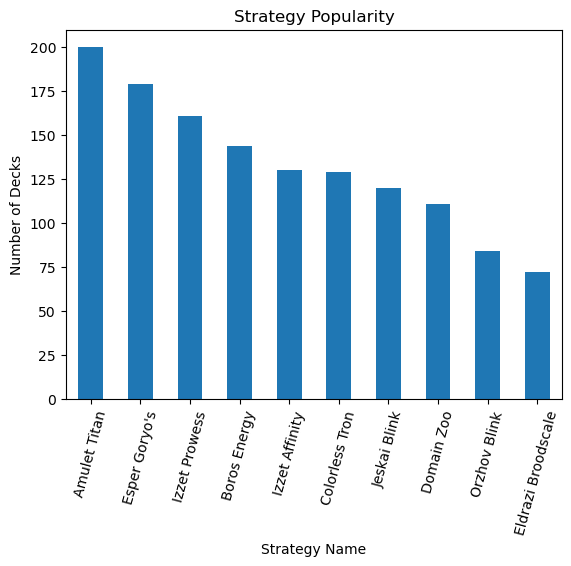

In [11]:
most_popular_decks = complete_participants.groupby("Deck Name").size().sort_values(ascending=False).head(10).index
strategy_popularity_bar_chart = complete_participants.groupby("Deck Name").size().sort_values(ascending=False).copy()
strategy_popularity_bar_chart.head(10).plot.bar(rot=75).set_ylabel("Number of Decks")
plt.xlabel("Strategy Name")
plt.title('Strategy Popularity')
plt.show()
#This shows how How popular a deck has been over the last 3 months.

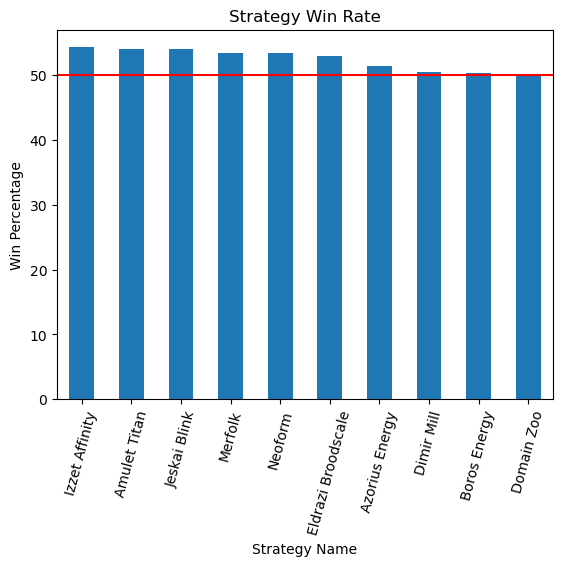

In [24]:
# Bar plot for win percentage
# Creates a variable to hold the 10 highest winrate decks
highest_winrate_decks = win_percentages_overall[(win_percentages_overall["Total Games"] > 60)].sort_values(by="Win Percentage", ascending=False)['Deck Name'].head(10).values
# Filtered out low total games to reduce outliers
win_percentages_overall[(win_percentages_overall["Total Games"] > 60)].sort_values(by="Win Percentage", ascending=False).head(10).plot.bar(x="Deck Name", y="Win Percentage",rot=75, legend=False).set_ylabel("Win Percentage")
plt.xlabel("Strategy Name")
plt.title('Strategy Win Rate')
plt.axhline(50, color='r')
# this is the top 10 win percentages of decks. Note where the most popular decks are.

In [13]:
# # Plots all the deck win totals
# for deck in highest_winrate_decks:
#     complete_wins_per_deck[deck].value_counts().sort_index().plot.bar(subplots=True)
#     plt.ylabel("Count")
#     plt.xlabel("Number of Wins")
#     plt.title(deck)
#     plt.show()

Text(0.5, 1.0, 'Winrate Distribution')

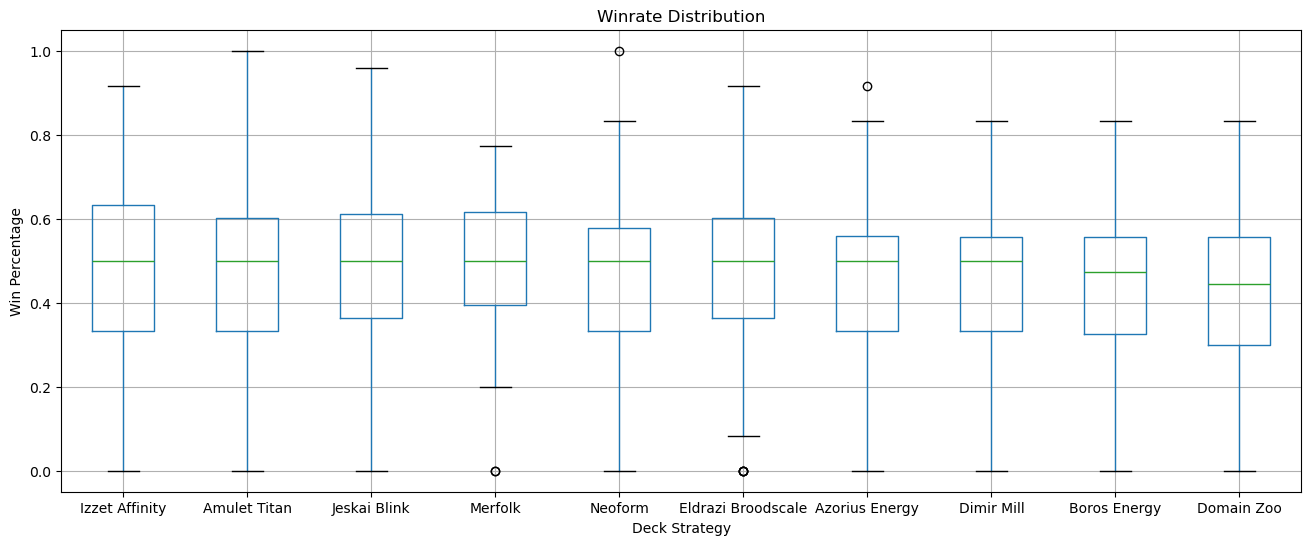

In [14]:
complete_winrate_per_deck[highest_winrate_decks].boxplot(figsize=(16,6))
plt.ylabel('Win Percentage')
plt.xlabel('Deck Strategy')
plt.title("Winrate Distribution")
#This graph shows the distribution of wins for the top 10 most winning decks.
# Outliers are very high finishes in tournaments. Outliers = GOOD if they are not too far from the edge of the boxplot ( greater than 10 )
# Comparing the last two strategies, boros energy and domain zoo, you can see that they are very similar in thier consistancy
# But boros energy has a higher finish. this could influence your descision since that strategy has proven itself in the past
# 

In [15]:
# Calculates win percentages of each deck against each other deck
deck_win_percentage_against_each_deck = set_winrate_per_deck_for_each_deck(round_win_round_loss(complete_rounds, complete_participants, deck_names), deck_names)


Text(0.5, 1.0, 'Matchup Win Percentages')

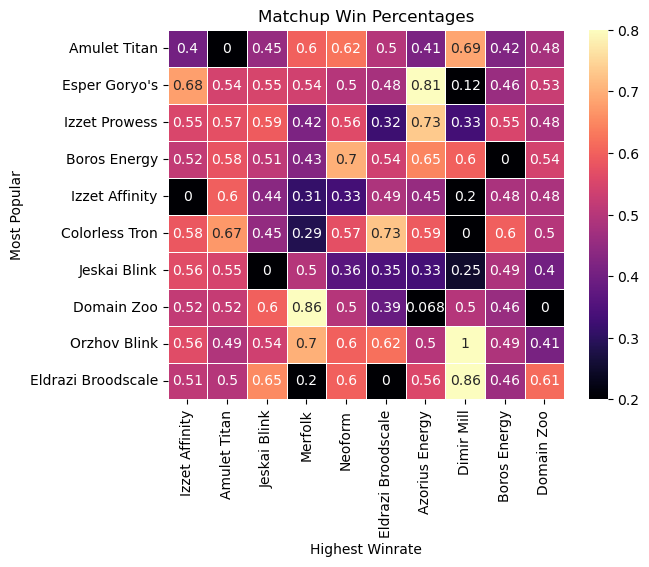

In [16]:
# Created a heatmap only using the top 10 most popular decks vs the top 10 winrate decks
sns.heatmap(deck_win_percentage_against_each_deck.loc[most_popular_decks, highest_winrate_decks], cmap='magma', annot=True, linewidth=.5, vmin=.2, vmax=.8)
plt.xlabel('Highest Winrate')
plt.ylabel('Most Popular')
plt.title('Matchup Win Percentages')

Text(0.5, 1.0, 'Matchup Win Percentages')

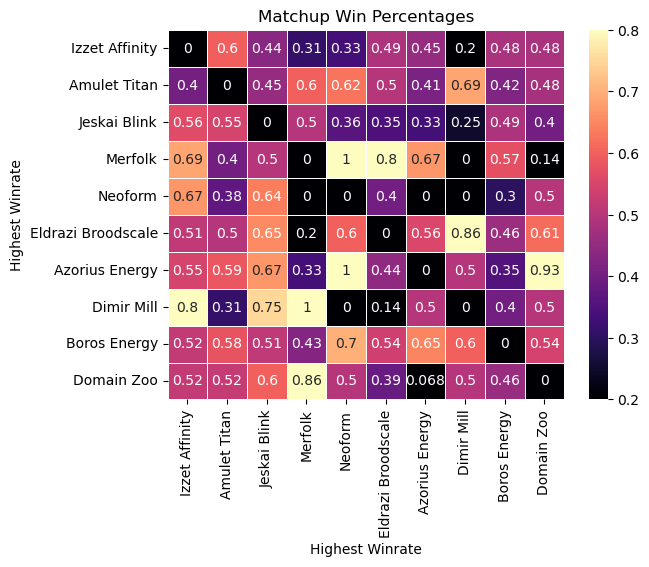

In [17]:
# Created a heatmap only using the top 10 win rate decks vs the top 10 winrate decks
sns.heatmap(deck_win_percentage_against_each_deck.loc[highest_winrate_decks, highest_winrate_decks], cmap='magma', annot=True, linewidth=.5, vmin=.2, vmax=.8)
plt.xlabel('Highest Winrate')
plt.ylabel('Highest Winrate')
plt.title('Matchup Win Percentages')